# Simple k-Means Clustering

Using the IMDB data, construct a feature matrix, and apply `k-Means` to the data to extract clusters. 

We then inspect various aspects of probability associated with these clusterings.

In [1]:
%matplotlib inline

In [2]:
import json

import pandas as pd
import numpy as np

from scipy.sparse import lil_matrix

import matplotlib.pyplot as plt

In [3]:
known_movies = set()

user_ratings = {} # List of all our movie ratings for specific users
movie_ids = []

with open("../data/user_ratings.json", "r") as in_file:
    for line in in_file:
        
        this_rating = json.loads(line)
        
        known_movies.add(this_rating["title_id"])
        
        if this_rating["title_id"] not in movie_ids:
            movie_ids.append(this_rating["title_id"])
        
        this_users_ratings = user_ratings.get(this_rating["userId"], [])
        this_users_ratings.append((this_rating["title_id"], this_rating["rating"]))
        
        user_ratings[this_rating["userId"]] = this_users_ratings
        
        

In [4]:
movie_id_to_index = {m:i for i,m in enumerate(movie_ids)}

In [5]:
print("Known Users:", len(user_ratings))
print("Known Movies:", len(known_movies))


Known Users: 2244
Known Movies: 4465


In [6]:
actor_id_to_name_map = {}     # Map Actor IDs to actor names
actor_id_to_index_map = {}    # Map actor IDs to a unique index of known actors
index_to_actor_ids = []       # Array mapping unique index back to actor ID (invert of actor_id_to_index_map)

index_counter = 0    # Unique actor index; increment for each new actor
known_actors = set()

movie_actor_map = {} # List of all our movies and their actors

test_count = 0
with open("../data/imdb_recent_movies.json", "r") as in_file:
    for line in in_file:
        
        this_movie = json.loads(line)
        
        # Restrict to known movies
        if this_movie["title_id"] not in known_movies:
            continue
            
        # Keep track of all the actors in this movie
        for actor_id,actor_name in zip(this_movie['actor_ids'],this_movie['actor_names']):
            
            # Keep names and IDs
            actor_id_to_name_map[actor_id] = actor_name
            
            # If we've seen this actor before, skip...
            if actor_id in known_actors:
                continue
                
            # ... Otherwise, add to known actor set and create new index for them
            known_actors.add(actor_id)
            actor_id_to_index_map[actor_id] = index_counter
            index_to_actor_ids.append(actor_id)
            index_counter += 1
            
        # Finished with this film
        movie_actor_map[this_movie["title_id"]] = ({
            "movie": this_movie["title_name"],
            "actors": set(this_movie['actor_ids']),
            "genres": this_movie["title_genre"]
        })

In [7]:
print("Known Actors:", len(known_actors))
print("Known Movies:", len(movie_actor_map))

Known Actors: 5224
Known Movies: 4465


## Generate DataFrame using Sparse Matrics

Convert our Movie Ratings data into a DataFrame that we can use for analysis.

In [8]:
# With sparse matrix, initialize to size of Users x Movies of 0s
matrix_sparse = lil_matrix((len(user_ratings), len(known_movies)), dtype=float)

# Update the matrix, user by user, setting non-zero values for the appropriate actors
for row,this_user in enumerate(user_ratings): 
    this_user_ratings = user_ratings[this_user]
    
    for movie_id,rating in this_user_ratings:
        this_movie_index = movie_id_to_index[movie_id]
        matrix_sparse[row,this_movie_index] = rating

In [9]:
df = pd.DataFrame.sparse.from_spmatrix(
    matrix_sparse, 
    index=[u for u in user_ratings],
    columns=movie_ids
).T
df

,10,37,51,126,152,263,284,448,626,706,...,162002,162073,162207,162257,162363,162420,162434,162464,162499,162537
tt0274309,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0298203,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0315733,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0337563,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0463854,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt4241904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
tt1666800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
tt6806448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0844671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [10]:
print("Movies x Users dimensionality:", df.shape)

Movies x Users dimensionality: (4465, 2244)


## Apply k-Means Clustering to the Movies Data

Use k-Means to cluster movies based on their user ratings, so we can extract probabilities around genre and related information.

In [11]:
from sklearn.cluster import MiniBatchKMeans

In [12]:
model = MiniBatchKMeans(n_clusters=16, n_init=128, max_iter=2048, tol=0.5, reassignment_ratio=0.5, random_state=31337)
model.fit(df)

MiniBatchKMeans(max_iter=2048, n_clusters=16, n_init=128, random_state=31337,
                reassignment_ratio=0.5, tol=0.5)

In [13]:
cluster_df = pd.DataFrame(zip(df.index, model.labels_), columns=["movie_id", "cluster"])

In [14]:
cluster_df

,movie_id,cluster
0,tt0274309,10
1,tt0298203,10
2,tt0315733,10
3,tt0337563,10
4,tt0463854,10
...,...,...
4460,tt4241904,0
4461,tt1666800,6
4462,tt6806448,6
4463,tt0844671,0


In [15]:
cluster_df["cluster"].value_counts()

0     2821
10    1269
5       80
14      72
6       70
8       49
9       35
7       18
11      18
4       16
1        6
2        5
13       3
12       1
3        1
15       1
Name: cluster, dtype: int64

In [16]:
for cluster,cluster_group in cluster_df.groupby("cluster"):
    print("Cluster:", cluster, ", Size:", cluster_group.shape[0])
    
    genre_counter = {}
    actor_counter = {}
    print("\t", "Movie Sample:")
    
    print_limit = min(10, cluster_group.shape[0])
    for m in cluster_group.sample(n=print_limit).itertuples():
        print("\t\t", movie_actor_map[m[1]]["movie"])
        
    this_movie_match = [movie_actor_map[movie] for movie in cluster_group["movie_id"]]
    for movie in this_movie_match:
        for g in movie["genres"]:
            genre_counter[g] = genre_counter.get(g, 0) + 1
        for g in movie["actors"]:
            actor_counter[g] = actor_counter.get(g, 0) + 1
    
    print("\t", "Genres:")
    for g in sorted(genre_counter, key=genre_counter.get, reverse=True)[:10]:
        print("\t\t", g, genre_counter[g])
    print("\t", "Actors:")
    for a in sorted(actor_counter, key=actor_counter.get, reverse=True)[:10]:
        print("\t\t", actor_id_to_name_map[a], actor_counter[a])
    



Cluster: 0 , Size: 2821
	 Movie Sample:
		 Precious Cargo
		 Special
		 I Want You
		 Identity Thief
		 Hostel: Part II
		 Cam-Girl
		 Gloria
		 The Whisperer in Darkness
		 Seraphim Falls
		 Going in Style
	 Genres:
		 Drama 1783
		 Comedy 1074
		 Romance 596
		 Crime 486
		 Action 449
		 Thriller 419
		 Horror 333
		 Mystery 297
		 Adventure 262
		 Biography 204
	 Actors:
		 Ewan McGregor 15
		 John Cusack 12
		 Dennis Quaid 12
		 Bruce Willis 12
		 Nicolas Cage 12
		 Samuel L. Jackson 12
		 Colin Farrell 11
		 Jim Broadbent 11
		 Tom Wilkinson 11
		 Cillian Murphy 11
Cluster: 1 , Size: 6
	 Movie Sample:
		 Underworld: Rise of the Lycans
		 Dracula 2000
		 My Name Is Bruce
		 Queen of the Damned
		 Dreamcatcher
		 Dog Soldiers
	 Genres:
		 Horror 5
		 Fantasy 4
		 Action 3
		 Drama 2
		 Thriller 2
		 Sci-Fi 1
		 Comedy 1
	 Actors:
		 Stuart Townsend 1
		 Vincent Perez 1
		 Thomas Jane 1
		 Jason Lee 1
		 Morgan Freeman 1
		 Damian Lewis 1
		 Jonny Lee Miller 1
		 Gerard Butler 1
		 C

## Elbow Method for Finding Reasonable k

Here, these optimization methods help us much more.

We use the "inertia" metric provided by the k-means model to evaluate cluster quality. As intertia decreases, the quality of the clustering increases.

We want to find an approximate inflection point in the intertia curve with a k value that changes from steep to shallow decreases in the inertia metric.

In [17]:
# Let us test different values of k
interia_scores = []

for test_k in sorted(set(np.random.randint(2,256,20))):
    print("Test k:", test_k)
    
    tmp_model = MiniBatchKMeans(
        n_clusters=test_k,  
        n_init=16, max_iter=2048, tol=0.5, reassignment_ratio=0.5
    )
    tmp_model.fit(df)
    
    score = tmp_model.inertia_
    interia_scores.append((test_k, score))

Test k: 6
Test k: 7
Test k: 31
Test k: 43
Test k: 50
Test k: 51
Test k: 65
Test k: 89
Test k: 92
Test k: 95
Test k: 116
Test k: 128
Test k: 132
Test k: 157
Test k: 163
Test k: 165
Test k: 210
Test k: 238
Test k: 241
Test k: 251


In [18]:
intertia_df = pd.DataFrame(interia_scores, columns=["k", "score"])

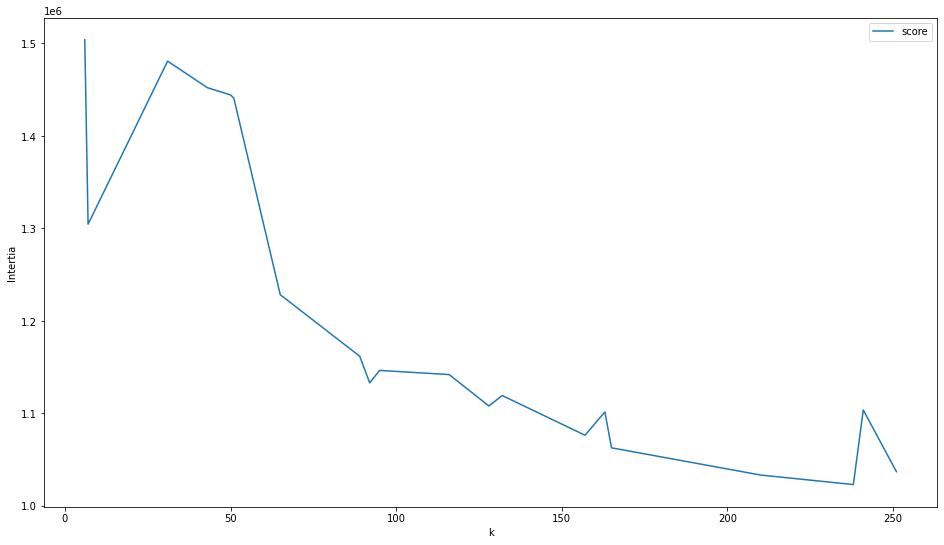

In [19]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)

intertia_df.sort_values(by="k").plot("k", "score", ax=ax)

ax.set_ylabel("Intertia")

plt.show()
